# Machine Learning Nanodegree Capstone Project

### __by Xiaolin Lin__

## Dataset for Project

In [1]:
import cv2
import pandas as pd
import numpy as np
import csv

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [2]:
print("train dataset structure:")
train.head()

train dataset structure:


,id,url,landmark_id
0,6e158a47eb2ca3f6,https://upload.wikimedia.org/wikipedia/commons...,142820
1,202cd79556f30760,http://upload.wikimedia.org/wikipedia/commons/...,104169
2,3ad87684c99c06e1,http://upload.wikimedia.org/wikipedia/commons/...,37914
3,e7f70e9c61e66af3,https://upload.wikimedia.org/wikipedia/commons...,102140
4,4072182eddd0100e,https://upload.wikimedia.org/wikipedia/commons...,2474


In [3]:
print("test dataset structure:")
test.head()

test dataset structure:


,id,url
0,cb9998b8cdaf6235,https://lh3.googleusercontent.com/-q8B91vDIQZY...
1,30728cf6e50a6bc6,https://lh3.googleusercontent.com/-91gJSKTgv5Q...
2,16afbc86b710337d,https://lh3.googleusercontent.com/-GHZdXuf2wMg...
3,d29b2166cf522450,https://lh3.googleusercontent.com/-cWDnYNQhyws...
4,dd5c03b20c21cfba,https://lh3.googleusercontent.com/-PSLN6BloM-k...


### Get top 100 most frequently appearing landmark_id from the original dataset

In [2]:
unique_lm = train.groupby(by='landmark_id').count().loc[:,'id']
sorted_lm = unique_lm.sort_values(ascending=False)
sorted_lm.cumsum()/sorted_lm.sum()

landmarks=train.groupby(by='landmark_id').count().loc[:,'id']
lm_stats = pd.concat([sorted_lm, sorted_lm/sorted_lm.sum(), sorted_lm.cumsum()/sorted_lm.sum()], axis=1, ignore_index=True)
lm_stats.columns=['Count', 'Proportion', 'CumSum']

# top 100 most frequent landmark_id for image selection
top_100 = lm_stats[0 : 100]

train_ordered = train[train.landmark_id.isin(top_100.index)]

# select 1% of images from each landmark_id
sample_group = train_ordered.groupby(by='landmark_id').apply(lambda x: x.sample(frac=0.02, random_state=17))
sample_index = sample_group.index.levels[1]

# sampling train data from original train dataset
train_sample = train.iloc[sample_index, :]

# write to csv file
train_sample.to_csv('train_sample.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)

train_sample = pd.read_csv('train_sample.csv')


In [3]:
print("Total train dataset size:", train.shape[0])
print("Total test dataset size:", test.shape[0])
print("Total number of unique landmark_id's:", len(landmarks))

print("Sampled train dataset size:", train_sample.shape[0])
print("Sampled unique landmark_id's:", len(train_sample["landmark_id"].unique()))

Total train dataset size: 4132914
Total test dataset size: 117703
Total number of unique landmark_id's: 203094
Sampled train dataset size: 2557
Sampled unique landmark_id's: 100


In [6]:
train_sample.head()

,id,url,landmark_id
0,b19a8e2a9f0459f9,https://upload.wikimedia.org/wikipedia/commons...,15427
1,8f874e2cb73af059,https://upload.wikimedia.org/wikipedia/commons...,47133
2,db0a6d8260b5ffaf,https://upload.wikimedia.org/wikipedia/commons...,1924
3,ce777bb778304709,http://upload.wikimedia.org/wikipedia/commons/...,46705
4,e6bc5d0d33e8cdef,https://upload.wikimedia.org/wikipedia/commons...,121873


## Analysis of Reduced Dataset

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

### Frequency of landmark_id in reduced dataset

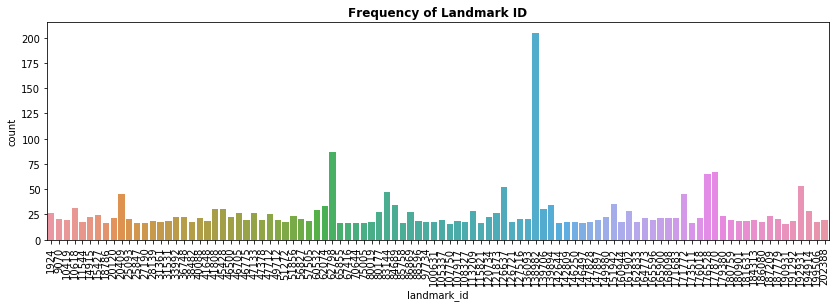

In [8]:
plt.figure(figsize = (14, 4))
g = sns.countplot(x="landmark_id", data=train_sample)
g.set_title("Frequency of Landmark ID", fontweight="bold", fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [9]:
train_sample['landmark_id'].value_counts()[:10]

138982    205
62798      87
177870     67
176528     65
192931     53
126637     52
83144      47
20409      45
171772     45
151942     35
Name: landmark_id, dtype: int64

In [10]:
train_sample.nunique()

id             2557
url            2557
landmark_id     100
dtype: int64

In [11]:
landmark_dist = train_sample['landmark_id'].value_counts() / train_sample.shape[0]
landmark_dist.head()

138982    0.080172
62798     0.034024
177870    0.026203
176528    0.025420
192931    0.020727
Name: landmark_id, dtype: float64

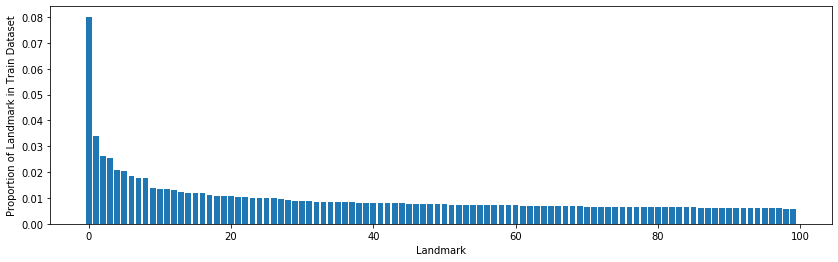

In [12]:
plt.figure(figsize = (14, 4))
fig = plt.bar(range(100), landmark_dist)
plt.xlabel("Landmark")
plt.ylabel("Proportion of Landmark in Train Dataset")
plt.savefig('./report/class_dist.png')

### Manually select two landmark images

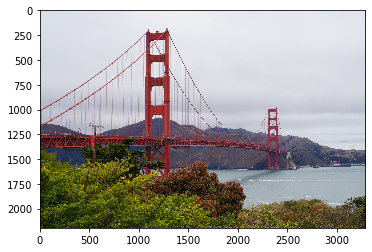

In [13]:
import cv2
img = cv2.imread('./train_images/283308fcc7c67fd5.jpg')
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(cv_rgb)
plt.show()

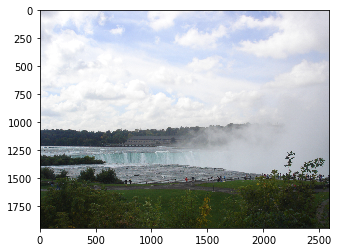

In [14]:
img = cv2.imread('./train_images/d4e484f0e0a172cf.jpg')
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(cv_rgb)
plt.show()

## Split dataset into train, validation and test

### Stratified sampling of training, validation and test dataset with 0.8, 0.1 and 0.1 split

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

X = train_sample['id']
y = train_sample['landmark_id']

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)

for train_id, test_id in sss.split(X, y):
    X_train, X_tmp = X.iloc[train_id], X.iloc[test_id]
    y_train, y_tmp = y.iloc[train_id], y.iloc[test_id]
    
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=10)

for train_id, test_id in sss1.split(X_tmp, y_tmp):
    X_valid, X_test = X_tmp.iloc[train_id], X_tmp.iloc[test_id]
    y_valid, y_test = y_tmp.iloc[train_id], y_tmp.iloc[test_id]

### Frequency of landmark_id in training dataset

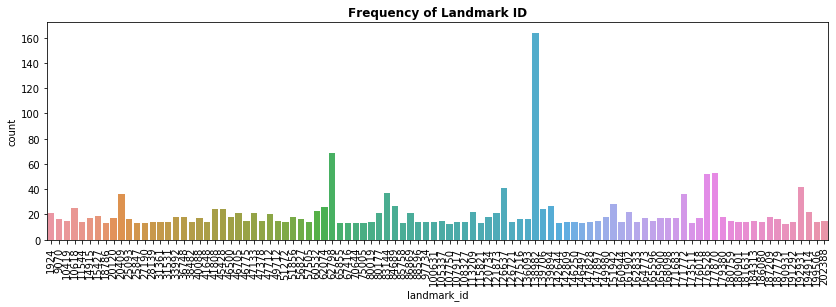

In [16]:
plt.figure(figsize = (14, 4))
h = sns.countplot(x=y_train)
h.set_title("Frequency of Landmark ID", fontweight="bold", fontsize=12)
plt.xticks(rotation=90)
plt.show()

### Frequency of landmark_id in test dataset

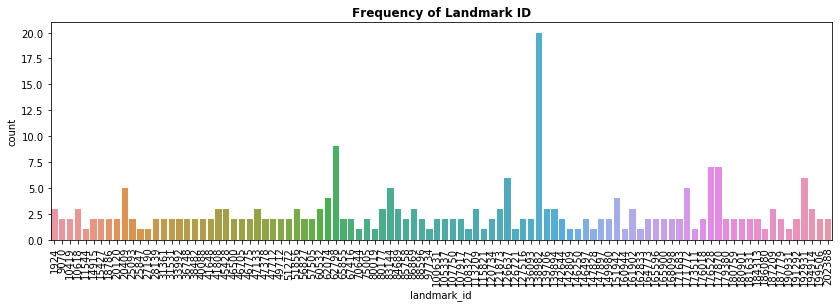

In [17]:
plt.figure(figsize = (14, 4))
h = sns.countplot(x=y_test)
h.set_title("Frequency of Landmark ID", fontweight="bold", fontsize=12)
plt.xticks(rotation=90)
plt.show()

## Benchmark Model - Random Guessing as base model
### Expected accuracy

In [3]:
from itertools import combinations

def expected_acc(prob_id):
    
    prob_id_c = 1 - prob_id
    prob_correct_number = []

    for i in range(len(prob_id)+1):

        id_comb = list(combinations(range(len(prob_id)), r=i))
        
        id_notcomb = [tuple(set(range(len(prob_id)))^set(x)) for x in id_comb]

        prob_comb = np.array([[prob_id[x] for x in id_comb[i]] for i in range(len(id_comb))])
        prob_notcomb = np.array([[prob_id_c[x] for x in id_notcomb[i]] for i in range(len(id_notcomb))])

        prob_num = np.hstack((prob_comb, prob_notcomb))
        ss = sum([np.prod(x) for x in prob_num])

        prob_correct_number.append(ss)

    expected_correct_num = sum(np.array(range(len(prob_id)+1)) * np.array(prob_correct_number))
    expected_accuracy = expected_correct_num / len(prob_id)
    
    return([expected_correct_num, expected_accuracy])

### Monte Carlo simulation of expected accuracy

In [6]:
import random

# Calculates probabilities of all landmark_id
prob_id = np.array([(y_test == id).sum() / len(y_test) for id in y_test]) 
seed = [3, 10, 27, 31, 48, 55, 67, 95, 105, 117]

expected_val_df = pd.DataFrame(columns=['E(x)', 'Accuracy'])

for i in seed:
    random.seed(i)
    randsample = random.sample(range(len(y_test)), 10)
    
    prob_id_montecarlo = prob_id[randsample]  # random selection of 20 images (instead of total test dataset)
    expected_val_df.loc[len(expected_val_df)] = expected_acc(prob_id_montecarlo)

In [20]:
expected_val_df

,E(x),Accuracy
0,0.207031,0.020703
1,0.144531,0.014453
2,0.125000,0.012500
3,0.164062,0.016406
4,0.152344,0.015234
5,0.121094,0.012109
6,0.230469,0.023047
7,0.113281,0.011328
8,0.121094,0.012109
9,0.164062,0.016406


In [21]:
round(expected_val_df.T,3)

,0,1,2,3,4,5,6,7,8,9
E(x),0.207,0.145,0.125,0.164,0.152,0.121,0.230,0.113,0.121,0.164
Accuracy,0.021,0.014,0.012,0.016,0.015,0.012,0.023,0.011,0.012,0.016


In [22]:
expected_val_df.mean()

E(x)        0.154297
Accuracy    0.015430
dtype: float64

## Create Train, Validation and Test Tensors for CNN

In [7]:
import os
from keras.preprocessing import image  
from tqdm import tqdm

img_shape = (192, 256) # Image shape (height, width)

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    ret = np.empty([192, 256, 3], dtype=int)
    if os.path.exists(img_path):
        try:
            img = image.load_img(img_path, target_size=img_shape)
            ret = image.img_to_array(img)
        except:
            pass
        # convert 3D tensor to 4D tensor with shape (1, 192, 256, 3)
        return  np.expand_dims(ret, axis=0)


def paths_to_tensor(img_paths):
    list_of_tensors = []
    for img_path in img_paths:
        tensor = path_to_tensor(img_path)
        list_of_tensors.append(tensor)
    print(len(list_of_tensors))
    return np.vstack(list_of_tensors)

Using TensorFlow backend.


In [8]:
from glob import glob
import os

train_path = './train_images/'
valid_path = './valid_images/'
test_path = './test_images/'


def load_dataset(path, train_sample):
    file_out = sorted(glob(path + '*'))
    file_out = np.array([s.replace("\\", "/") for s in file_out])
    label_out = pd.Series(name="landmark_id")
    
    for file in file_out:
        filebase = os.path.basename(file)
        name = os.path.splitext(filebase)[0]
        temp = train_sample.landmark_id[train_sample["id"] == name]
        label_out = label_out.append(temp)
        
    label_out = np.array(pd.get_dummies(label_out))
    
    return file_out, label_out

In [9]:
train_file, train_target = load_dataset(train_path, train_sample)
valid_file, valid_target = load_dataset(valid_path, train_sample)
test_file, test_target = load_dataset(test_path, train_sample)

In [10]:
print("Number of training images:", len(train_target))
print("Number of validation images:", len(valid_target))
print("Number of test images:", len(test_target))

Number of training images: 2045
Number of validation images: 256
Number of test images: 256


In [11]:
train_tensors = paths_to_tensor(train_file).astype('float32')/255
valid_tensors = paths_to_tensor(valid_file).astype('float32')/255
test_tensors  = paths_to_tensor(test_file).astype('float32')/255

2045
256
256


In [12]:
train_tensors.shape

(2045, 192, 256, 3)

### An exmple image of a train tensor and label

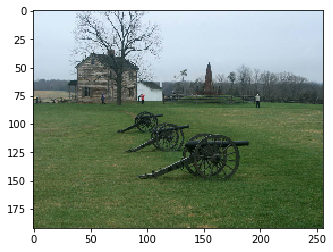

In [14]:
plt.imshow(train_tensors[2])

In [15]:
train_target[2].shape

(100,)

## Base CNN Model
### Model Compile

In [13]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

In [14]:
input_shape = img_shape + (3,)

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=4, padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(100, activation='softmax'))

model.summary()

W0930 17:11:16.969716 139862630598464 deprecation_wrapper.py:119] From /home/xiaolin/anaconda3/envs/myenv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0930 17:11:17.048843 139862630598464 deprecation_wrapper.py:119] From /home/xiaolin/anaconda3/envs/myenv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0930 17:11:17.074721 139862630598464 deprecation_wrapper.py:119] From /home/xiaolin/anaconda3/envs/myenv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0930 17:11:17.118359 139862630598464 deprecation_wrapper.py:119] From /home/xiaolin/anaconda3/envs/myenv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecate

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 192, 256, 16)      784       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 96, 128, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 128, 32)       4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 32, 128)       32896     
__________

In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

W0930 17:11:22.632369 139862630598464 deprecation_wrapper.py:119] From /home/xiaolin/anaconda3/envs/myenv/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0930 17:11:22.653485 139862630598464 deprecation_wrapper.py:119] From /home/xiaolin/anaconda3/envs/myenv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



### Model Train

In [16]:
from keras.callbacks import ModelCheckpoint

epochs = 10

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_baseCNN.hdf5', 
                               verbose=1, save_best_only=True)

hist = model.fit(train_tensors, train_target, 
          validation_data=(valid_tensors, valid_target),
          epochs=epochs, batch_size=64, callbacks=[checkpointer], verbose=1)

W0930 17:11:49.407051 139862630598464 deprecation.py:323] From /home/xiaolin/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2045 samples, validate on 256 samples
Epoch 1/10
2045/2045 [==============================] - 76s 37ms/step - loss: 12.0367 - acc: 0.0733 - val_loss: 11.2192 - val_acc: 0.0820

Epoch 00001: val_loss improved from inf to 11.21923, saving model to saved_models/weights.best.from_baseCNN.hdf5
Epoch 2/10
2045/2045 [==============================] - 73s 36ms/step - loss: 11.8956 - acc: 0.0802 - val_loss: 11.2075 - val_acc: 0.0820

Epoch 00002: val_loss improved from 11.21923 to 11.20747, saving model to saved_models/weights.best.from_baseCNN.hdf5
Epoch 3/10
2045/2045 [==============================] - 73s 36ms/step - loss: 12.1695 - acc: 0.0641 - val_loss: 11.8464 - val_acc: 0.0469

Epoch 00003: val_loss did not improve from 11.20747
Epoch 4/10
2045/2045 [==============================] - 73s 36ms/step - loss: 12.2446 - acc: 0.0606 - val_loss: 11.8408 - val_acc: 0.0469

Epoch 00004: val_loss did not improve from 11.20747
Epoch 5/10
2045/2045 [==============================] - 72s 35

### Test Accuracy

In [17]:
model.load_weights('saved_models/weights.best.from_baseCNN.hdf5')
landmark_pred = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
landmark_prob = [np.amax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# landmark_pred = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
test_accuracy = np.sum(np.array(landmark_pred) == np.argmax(test_target, axis=1)) / len(landmark_pred)
print('Test accuracy:', test_accuracy)

Test accuracy: 0.078125


## Global Average Precision (GAP) Evaluation

In [18]:
# Sort the predicted landmark lable and test label based on softmax probability

sort_id = np.argsort(landmark_prob)[::-1]
landmark_pred_sorted = [landmark_pred[sid] for sid in sort_id]
test_target_sorted = [test_target[sid] for sid in sort_id]

In [19]:
# Calculate GAP score

prec = []

for i in range(len(sort_id)):
    prec.append(np.sum(np.array(landmark_pred_sorted[:(i+1)]) == np.argmax(test_target_sorted[:(i+1)], axis=1)) 
                / len(landmark_pred_sorted[:(i+1)]))

GAP_score = np.sum(prec) / len(prec)
GAP_score

0.06446028927350278